# 손실함수 (Loss Function)

### Huber Loss

In [17]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [18]:
y_true = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
y_pred = np.array([1.2, 1.8, 3.1, 3.9, 4.8])

y_true = np.append(y_true, [50.0, 60.0])
y_pred = np.append(y_pred, [10.0, 5.0])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("MSE", mse)
print("MAE", mae)

MSE 660.7342857142858
MAE 13.685714285714285


In [19]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss(y_true, y_pred)

np.float64(13.438571428571427)

### 신경망 모델에서 손실 함수 활용

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 생성
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

# 전처리
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)

def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test, 2)

In [21]:
# 모델 파라미터 초기화
np.random.seed(42)

input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 2

W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))

In [22]:
# 활성화 함수, 손실 함수 정의
def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs, labels):
    m = labels.shape[0]
    log_likelihood = -np.log(probs + 1e-8) * labels    # 1e-8 = 1*10^(-8)
    loss = np.sum(log_likelihood) / m
    return loss

In [23]:
# 학습
learning_rate = 0.01
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Forward
    Z1 = np.dot(X_train, W1) + b1
    R1 = relu(Z1)    # (hidden_dim, output_dim)
    Z2 = np.dot(R1, W2) + b2
    probs = softmax(Z2)
    loss = cross_entropy_loss(probs, y_train_oh)

    # Backpropagation
    m = X_train.shape[0]
    dZ2 = (probs - y_train_oh) / m    # (N, output_dim)
    dW2 = np.dot(R1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dR1 = np.dot(dZ2, W2.T)
    dZ1 = dR1 * (Z1 > 0)
    dW1 = np.dot(X_train.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # 파라미터 업데이트
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(loss)
    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test)
    loss_test = cross_entropy_loss(probs_test, y_test_oh)

    test_losses.append(loss_test)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | 학습 손실: {loss:.4f}, 테스트 손실: {loss_test:.4f}")

Epoch 10 | 학습 손실: 4.4511, 테스트 손실: 4.4685
Epoch 20 | 학습 손실: 4.0039, 테스트 손실: 4.0507
Epoch 30 | 학습 손실: 3.6635, 테스트 손실: 3.7196
Epoch 40 | 학습 손실: 3.3840, 테스트 손실: 3.4576
Epoch 50 | 학습 손실: 3.1472, 테스트 손실: 3.2343


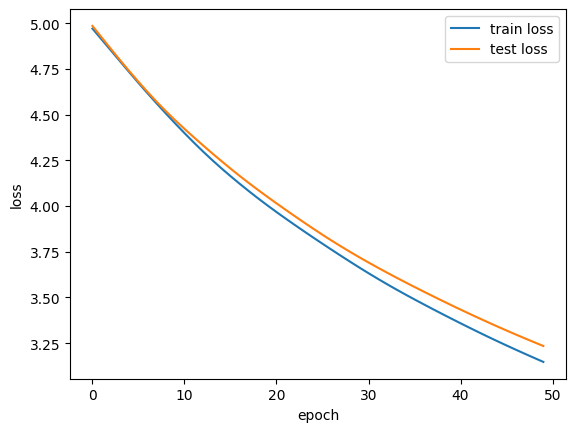

In [24]:
# 시각화
plt.plot(range(epochs), train_losses, label="train loss")
plt.plot(range(epochs), test_losses, label="test loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()